# Project 3 Computer Vision

* Kajetan Sulwiński 151954
* Mikołaj Marmurowicz 151956

## Necessary imports and helper functions.

In [1]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import model_from_json
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError
import pickle

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

In [2]:
def imshow(img):
    plt.imshow(img, cmap='Greys')
    plt.show()

In [3]:
def drawKeypoints(pred, img):
    out = cv2.cvtColor((img.copy() *255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    for i in range(0, len(pred), 2):
        x, y = int(pred[i]), int(pred[i + 1])
        cv2.circle(out, (x, y), 3, (255, 0, 0), -1)
    return out

In [4]:
def saveModel(model, history, model_json_path, model_weights_path, model_history_path):
    model_json = model.to_json()
    with open(model_json_path, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_weights_path)
    with open(model_history_path, 'wb') as pickle_file:
        pickle.dump(history.history, pickle_file)

def loadModel(model_path, model_weights_path, model_history_path):
    with open(model_path, "r") as json_file:
        loaded_model_json = json_file.read()
        loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_path)
    with open(model_history_path, "rb") as pickle_file:
        history = pickle.load(pickle_file)
    return loaded_model, history

## Data loading.

Our dataset consisted of 4 files:

* IDLookupTable.csv - not needed for our purpose
* SampleSubmission.csv - not needed for our purpose
* test.zip containing test.csv - file represents unfilled data that was supposed to be uploaded to the kaggle platform to test the results, thus we will not be using that.
* training.zip containig training.csv - the file that we will use for all train, validation and test sets.

This dataset consisted of 7049 images of size (96x96) as well as their keypoints. Sadly most of the keypoints were not full, thus we needed to discrad most of the data. In the end we had 2140 full data points to work with.

In [5]:
data = pd.read_csv('training/training.csv')

In [6]:
X_data = []
y_data = []
for index, row in data.iterrows():
    image = np.reshape(np.array(row['Image'].split(' '), dtype=int), (96, 96, 1))
    X_data.append(image)
    keypoints_values = row.iloc[:-1].values.astype(np.float32)
    y_data.append(keypoints_values)

X_data = np.array(X_data)
y_data = np.array(y_data)

In [7]:
nan_mask = np.isnan(y_data)
rows_without_nan = ~np.any(nan_mask, axis=1)
X_data = X_data[rows_without_nan]
y_data = y_data[rows_without_nan]
print(X_data.shape)
print(y_data.shape)

(2140, 96, 96, 1)
(2140, 30)


Resizing each image to fit the requirements of 224x224 image size.

In [8]:
min = 0
max = 255
X_data = (X_data - min) / (max - min)
resized_images = []
for image in X_data:
    resized_image = cv2.resize(image, (224, 224))
    resized_images.append(resized_image)

X_data = np.array(resized_images)
y_data = y_data * (224/96)

In [9]:
print(X_data.shape)
print(y_data.shape)

(2140, 224, 224)
(2140, 30)


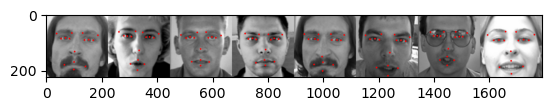

In [10]:
imshow(np.concatenate([drawKeypoints(true, img) for true, img in zip(y_data[:8], X_data[:8])],1))

In [11]:
y_df = pd.DataFrame(y_data, columns = data.columns[:-1])
y_df.head(5)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,154.078308,91.005302,70.529678,84.983910,139.024841,92.510651,170.637466,93.263321,84.831993,87.241928,...,103.647995,133.155869,142.789047,186.597061,66.767159,180.574310,101.062737,170.182724,100.638313,197.133453
1,150.110184,81.596848,69.881645,78.046997,137.331055,82.306808,165.019684,84.436714,84.081024,80.176903,...,112.481361,129.875504,131.650040,178.154648,81.952225,177.444534,108.930725,163.955292,106.091797,199.453720
2,151.799789,81.455826,72.108841,81.455826,138.627991,84.748924,165.630310,84.748924,87.915573,84.748924,...,110.966942,124.924210,141.920212,170.366730,78.694733,169.707993,110.308212,163.780838,110.308212,183.538528
3,152.193390,86.944130,74.720551,86.944130,140.007782,91.296745,168.734329,89.555588,87.776833,90.426270,...,121.065178,126.388588,153.064056,169.642014,86.906151,173.122787,117.374046,163.547272,120.309425,182.626205
4,155.692368,92.449608,75.237885,88.764732,136.653748,92.449608,169.203827,93.063759,86.292213,91.221321,...,101.032242,151.408875,141.566620,180.887558,72.780762,179.660355,104.913078,171.983902,103.196663,202.699371


Splitting real data into 3 sets:
* training (70%)
* validation (15%)
* test (15%)

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size = 0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5)

## Data generation.

We have decided to generate data based on the examples in the dataset by rotation, scaling and translation.

In [13]:
def model_output_to_keypoints_coordinates(output: np.array) -> dict:
    ret = {}
    for i in range(0, len(data.columns[:-1]), 2):
        keypoint_name = data.columns[i][:-2]
        keypoint_coordinates = output[(i):(i+2)]
        ret[keypoint_name] = keypoint_coordinates
    return ret

Data generation class to customize the image generation along with the keypoints.

In [14]:
class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        X_data: np.array,
        y_data: np.array,
        batch_size: int,
        shuffle: bool = True,
        aug: iaa.Augmenter = None
    ):
        self.X_data = X_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.aug = aug
        self.indexes = np.arange(len(self.X_data))
        self.on_epoch_end()

    def _data_generation(self, index_array):
        keypoints_ret = np.zeros_like(self.y_data[index_array])
        images_ret = np.zeros_like(self.X_data[index_array])
        if self.aug is not None:
            for i, index in enumerate(index_array):
                kps = []
                kps_cords = model_output_to_keypoints_coordinates(self.y_data[index])
                for _, keyp in kps_cords.items():
                    kps.append(Keypoint(x=keyp[0], y=keyp[1]))
                kps_obj = KeypointsOnImage(kps, shape=self.X_data[index].shape)
                augmented_img, augmented_kps = self.aug(image=self.X_data[index], keypoints=kps_obj)
                augmented_kps = np.array([[kp.x, kp.y] for kp in augmented_kps.keypoints])
                augmented_kps = augmented_kps.flatten()
                keypoints_ret[i] = augmented_kps
                images_ret[i] = augmented_img
        return images_ret, keypoints_ret
    
    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        return self._data_generation(batch_indexes)

Examplary generated data.

(2112, 224, 224)
(2112, 30)


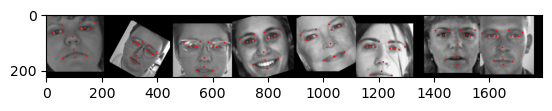

In [15]:
INPUT_SIZE = (224, 224, 1)

aug = iaa.Sequential(
    [
        iaa.Resize(INPUT_SIZE[:2], interpolation="linear"),
        iaa.Fliplr(0.1),
        iaa.Sometimes(0.8, iaa.Affine(rotate=(-40, 40), scale=(0.75, 1.25))),
        iaa.Sometimes(0.8, iaa.Affine(translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}))
    ]
)

gen = DataGenerator(X_data, y_data, 32, aug=aug)

aug_X = []
aug_y = []
for epoch in range(1):
    gen.on_epoch_end()
    for batch_index in range(len(gen)):
        X_batch, y_batch = gen[batch_index]
        aug_X.append(X_batch)
        aug_y.append(y_batch)
aug_X = np.array(aug_X)
aug_y = np.array(aug_y)

aug_X = aug_X[:, :, :, :].reshape((-1,) + (224,224))
aug_y = aug_y[:, :, :].reshape((-1, 30))
print(aug_X.shape)
print(aug_y.shape)
imshow(np.concatenate([drawKeypoints(keypoints,image) for keypoints, image in zip(aug_y[:8], aug_X[:8])], 1))

Creating instances of generators for each train, validation and test sets seperately.

In [16]:
batch_size = 32
train_data_generator = DataGenerator(X_train, y_train, batch_size, True, aug)
val_data_generator = DataGenerator(X_val, y_val, batch_size, True, aug)
test_data_generator = DataGenerator(X_test, y_test, batch_size, True, aug)

## Model 1

The first model that we created consists of 3 convolution blocks, flattening layer, 2 fully connected layers and output layer.

In [17]:
def createModel(input_shape, num_keypoints):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))

    model.add(layers.Dense(num_keypoints, activation='linear'))

    return model


input_shape = (224, 224,1)
num_keypoints = y_data.shape[1]

model = createModel(input_shape, num_keypoints)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

Creating an early stopping condition with patience = 8 along with learning rate reduction on plateau callback with patience = 8.

In [18]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
LR_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=10, factor=.5, min_lr=.0000001)

Now we train the model on the generated data with validation set that is also generated/ loading the previously trained model. 

That means that training set in total conists of approximately 

$(2140 * 0.7 // 32) * 32 * 20 = 29440$ (1472 per epoch) examples

The validation set consists of 

$(2140 * 0.15 // 32) * 32 * 20 = 6400$ (320 per epoch) examples.

In [19]:
# num_batches = 20
# history = model.fit(train_data_generator, epochs=num_batches, validation_data=val_data_generator, callbacks=[early_stopping, LR_callback])

In [20]:
model, history = loadModel('model1.json', 'model_weights1.h5', 'model_history1.pickle')

Now we create 10 000 examples (10240 to be exact) for the evaluation of the model (test set) via previously created test data generator.

In [21]:
aug_X_test = []
aug_y_test = []
for epoch in range(10000 // len(X_test) + 1):
    test_data_generator.on_epoch_end()
    for batch_index in range(len(test_data_generator)):
        X_batch_test, y_batch_test = test_data_generator[batch_index]
        aug_X_test.append(X_batch_test)
        aug_y_test.append(y_batch_test)
aug_X_test = np.array(aug_X_test)
aug_y_test = np.array(aug_y_test)

aug_X_test = aug_X_test[:, :, :, :].reshape((-1,) + (224,224))
aug_y_test = aug_y_test[:, :, :].reshape((-1, 30))
print(aug_X_test.shape)
print(aug_y_test.shape)

(10240, 224, 224)
(10240, 30)


Make predictions.

In [22]:
y_pred = model.predict(aug_X_test)

320/320 [==============================] - 80s 242ms/step


Results of evaluation.

Mean squared error on test set = 610.0864868164062.


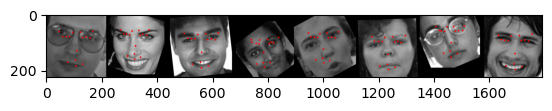

In [23]:
y_pred_flat = y_pred.flatten()
aug_y_test_flat = aug_y_test.flatten()

mse1 = mean_squared_error(y_pred_flat, aug_y_test_flat)
print(f"Mean squared error on test set = {mse1}.")
imshow(np.concatenate([drawKeypoints(keypoints,image) for keypoints, image in zip(y_pred[:8], aug_X_test[:8])], 1))

Saving the model along with its weights and history.

In [24]:
# saveModel(model, history, 'model1.json', 'model_weights1.h5', 'model_history1.pickle')

## Model 2

The second model that we have created consists of a convolutional block, after which a pretrained MobileNetV2 model is used, at the end we have an dropout and pooling layer with the output layer.

In [25]:
def createModel2(input_shape, num_keypoints):
    model2 = keras.models.Sequential()

    pretrained_model = keras.applications.MobileNetV2(
        input_shape=input_shape[:2] + (3,),
        alpha=1.0,
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        pooling=None,
    )
    pretrained_model.trainable = True

    model2.add(layers.Convolution2D(3, (1, 1), padding='same', input_shape=input_shape))
    model2.add(layers.LeakyReLU(alpha = 0.1))
    model2.add(layers.Lambda(keras.applications.mobilenet.preprocess_input))

    model2.add(pretrained_model)

    model2.add(layers.Dropout(0.3))
    model2.add(layers.GlobalAveragePooling2D())
    model2.add(layers.Dense(num_keypoints, activation='relu'))
    
    return model2


input_shape = (224, 224,1)
num_keypoints = y_data.shape[1]

model = createModel2(input_shape, num_keypoints)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 3)       6         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 3)       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                               

Training the model with previously created callbacks and generators / loading the previously trained model.

In [26]:
# num_batches = 20
# history = model.fit(train_data_generator, epochs=num_batches, validation_data=val_data_generator, callbacks=[early_stopping, LR_callback])

In [27]:
model, history = loadModel('model2.json', 'model_weights2.h5', 'model_history2.pickle')

Evaluating the model performance with previosuly generated data.

In [28]:
y_pred = model.predict(aug_X_test)

320/320 [==============================] - 149s 450ms/step


Mean squared error on test set = 13049.8935546875.


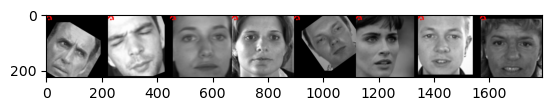

In [29]:
y_pred_flat = y_pred.flatten()

mse2 = mean_squared_error(y_pred_flat, aug_y_test_flat)
print(f"Mean squared error on test set = {mse2}.")
imshow(np.concatenate([drawKeypoints(keypoints,image) for keypoints, image in zip(y_pred[8:16], aug_X_test[8:16])], 1))

Saving the model along with its weights and history.

In [30]:
# saveModel(model, history, 'model2.json', 'model_weights2.h5', 'model_history2.pickle')

## Model 3

Now we have decided to slightly improve the overfitting of the first model, by applying small changes such as batch normalization and dropout in the convolutional blocks, while also changing the number of convolutional blocks.

In [31]:
def createModel3(input_shape, num_keypoints):
    model3 = keras.models.Sequential()

    model3.add(layers.Convolution2D(16, (3, 3), input_shape = input_shape, activation = 'relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPool2D())
    model3.add(layers.Dropout(0.3))

    model3.add(layers.Convolution2D(32, (3, 3)))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPool2D())
    model3.add(layers.Dropout(0.3))


    model3.add(layers.Convolution2D(64, (3, 3)))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPool2D())
    model3.add(layers.Dropout(0.3))

    model3.add(layers.Convolution2D(128, (3, 3)))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPool2D())
    model3.add(layers.Dropout(0.3))

    model3.add(layers.Flatten())

    model3.add(layers.Dense(256, activation='relu'))
    model3.add(layers.Dropout(0.5))
    model3.add(layers.Dense(128, activation='relu'))
    
    model3.add(layers.Dense(num_keypoints, activation='linear'))
    
    return model3

input_shape = (224, 224,1)
num_keypoints = y_data.shape[1]

model = createModel3(input_shape, num_keypoints)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError()])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 111, 111, 16)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 32)    

Training the model with previous callbacks and data generators / loading the model and its training history.

In [32]:
# num_batches = 20
# history = model.fit(train_data_generator, epochs=num_batches, validation_data=val_data_generator, callbacks=[early_stopping, LR_callback])

In [33]:
model, history = loadModel('model3.json', 'model_weights3.h5', 'model_history3.pickle')

Evaluating the model on previously created test set.

In [34]:
y_pred = model.predict(aug_X_test)

320/320 [==============================] - 40s 119ms/step


Mean squared error on test set = 884.5805053710938.


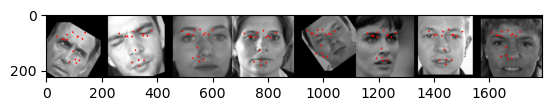

In [35]:
y_pred_flat = y_pred.flatten()

mse3 = mean_squared_error(y_pred_flat, aug_y_test_flat)
print(f"Mean squared error on test set = {mse3}.")
imshow(np.concatenate([drawKeypoints(keypoints,image) for keypoints, image in zip(y_pred[8:16], aug_X_test[8:16])], 1))

Saving the model with weights and history.

In [ ]:
# saveModel(model, history, 'model3.json', 'model_weights3.h5', 'model_history3.pickle')

## Model 4

Now we have decided to test the model 2, but using transfer learning, while also removing/ adding some additional layers. 

In [37]:
def createModel4(input_shape, num_keypoints):
    model4 = keras.models.Sequential()

    pretrained_model = keras.applications.MobileNetV2(
        input_shape=input_shape[:2] + (3,),
        alpha=1.0,
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        pooling=None,
        classifier_activation='linear'
    )
    pretrained_model.trainable = False

    model4.add(layers.Convolution2D(3, (1, 1), padding='same', input_shape=input_shape))
    model4.add(layers.LeakyReLU(alpha=0.1))
    model4.add(layers.Lambda(keras.applications.mobilenet.preprocess_input))

    model4.add(pretrained_model)
   
    model4.add(layers.Flatten())
    model4.add(layers.BatchNormalization())

    model4.add(layers.Dense(512, activation='relu'))
    model4.add(layers.Dropout(0.5))

    model4.add(layers.Dense(num_keypoints, activation='linear'))

    return model4

input_shape = (224, 224,1)
num_keypoints = y_data.shape[1]

model = createModel4(input_shape, num_keypoints)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError()])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 3)       6         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 224, 224, 3)       0         
                                                                 
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 62720)            250880    
 hNormalization)                                      

Model training/ loading.

In [38]:
# num_batches = 20
# history = model.fit(train_data_generator, epochs=num_batches, validation_data=val_data_generator, callbacks=[early_stopping, LR_callback])

Epoch 1/20
46/46 [==============================] - 153s 3s/step - loss: 4465.8779 - mean_absolute_error: 50.4802 - mean_absolute_percentage_error: 73.8786 - root_mean_squared_error: 66.8272 - val_loss: 4724.7217 - val_mean_absolute_error: 60.9308 - val_mean_absolute_percentage_error: 98.8551 - val_root_mean_squared_error: 68.7366 - lr: 0.0010
Epoch 2/20
46/46 [==============================] - 86s 2s/step - loss: 1090.8656 - mean_absolute_error: 24.9175 - mean_absolute_percentage_error: 49.6018 - root_mean_squared_error: 33.0283 - val_loss: 3229.1382 - val_mean_absolute_error: 49.8191 - val_mean_absolute_percentage_error: 143.5037 - val_root_mean_squared_error: 56.8255 - lr: 0.0010
Epoch 3/20
46/46 [==============================] - 83s 2s/step - loss: 920.5493 - mean_absolute_error: 22.5424 - mean_absolute_percentage_error: 38.8886 - root_mean_squared_error: 30.3406 - val_loss: 2468.1201 - val_mean_absolute_error: 42.6462 - val_mean_absolute_percentage_error: 76.4025 - val_root_mean_

In [41]:
model, history = loadModel('model4.json', 'model_weights4.h5', 'model_history4.pickle')

Predictions and evaluation.

In [40]:
y_pred = model.predict(aug_X_test)

MemoryError: Unable to allocate 1.91 GiB for an array with shape (10240, 224, 224) and data type float32

In [ ]:
y_pred_flat = y_pred.flatten()

mse4 = mean_squared_error(y_pred_flat, aug_y_test_flat)
print(f"Mean squared error on test set = {mse4}.")
imshow(np.concatenate([drawKeypoints(keypoints,image) for keypoints, image in zip(y_pred[8:16], aug_X_test[8:16])], 1))

Saving the model.

In [39]:
# saveModel(model, history, 'model4.json', 'model_weights4.h5', 'model_history4.pickle')

# Filters

In [ ]:
import json

class Filter:
    def __init__(self, json_descr_path: str):
        with open(json_descr_path, 'r') as f:
            data = json.load(f)
            self.image = cv2.imread(f"filters/{data['file_path']}")
            self.ref_points = data['reference_points']
    def show_image(self):
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
    def warp_to_points(self, points: dict) -> np.array:
        dst = []
        src = []
        for keypoint_name in self.ref_points:
            if keypoint_name in points:
                dst.append(points[keypoint_name])
                src.append(self.ref_points[keypoint_name])
        assert len(dst) == len(src) == 4
        src = np.array(src, dtype=np.float32)
        dst = np.array(dst, dtype=np.float32)
        matrix = cv2.getPerspectiveTransform(src, dst)
        return cv2.warpPerspective(self.image, matrix, (INPUT_SIZE[0], INPUT_SIZE[1]), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

glasses = Filter('filters/sunglasses.json')
glasses_warped = cv2.cvtColor(glasses.warp_to_points(keyps), cv2.COLOR_BGR2GRAY)
plt.imshow(glasses_warped, cmap='gray')

In [ ]:
def combine_image_and_filter(img: np.array, filter: np.array) -> np.array:
    pseudo_alpha_filter = (filter > 0).astype(np.uint8)
    inverse_pseudo_alpha_filter = np.ones(INPUT_SIZE[:2]) - pseudo_alpha_filter
    return filter * pseudo_alpha_filter + inverse_pseudo_alpha_filter * img.squeeze()

plt.imshow(combine_image_and_filter(img, glasses_warped), cmap = 'gray')